In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [2]:
X_train = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                  index_col=0)
print("Dimensionalidade dos dados: ", X_train.shape)
X_train.head()

Dimensionalidade dos dados:  (4051, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


In [3]:
hkg = ["adk","cysG","dnaG","ftsZ","gap","gmk","gyrA","gyrB","hcaT","idnT","recA",
       "rho","rpoA","rpoB","rpoC","rpoD","secA","recF","fusA","glnA","tuf"]

In [4]:
#X_train = X_train.sample(n=100)
X_train = X_train.loc[hkg].dropna()
X_train.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


(15, 9)

In [5]:
max_val = 1
min_val = -1
X_train = ((X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train)))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
adk,0.322919,0.306682,0.233249,0.252705,0.050682,0.140450,-0.239388,-0.104706,-0.020661
cysG,-0.886249,-0.924971,-0.921355,-1.000000,-0.999405,-0.877015,-0.869515,-0.346979,-0.514738
dnaG,0.280139,0.351892,0.346807,0.209852,0.128913,0.233587,0.229860,0.616064,0.376455
ftsZ,0.372777,0.332264,0.250828,0.435016,0.320205,0.264169,0.047409,-0.118242,0.075838
gmk,0.438312,0.392016,0.353727,0.510646,0.372934,0.429208,0.364839,0.821547,0.503494
gyrA,1.000000,0.981742,0.900146,0.744566,0.685601,0.627487,0.237213,-0.086462,0.298520
gyrB,0.361458,0.384045,0.406020,0.285252,0.235554,0.257692,0.360538,0.821872,0.596169
hcaT,-1.000000,-1.000000,-1.000000,-0.914986,-0.870975,-1.000000,-1.000000,-1.000000,-1.000000
idnT,-0.801205,-0.814623,-0.835418,-0.736056,-1.000000,-0.714558,-0.745359,-0.120887,-0.389636


In [60]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(32, input_shape=(self.noise_input,)))
        model.add(Dense(32))
        model.add(Dense(32))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [61]:
noise_input = 100
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  100


In [62]:
G.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_35 (Dense)             (None, 9)                 297       
_________________________________________________________________
reshape_4 (Reshape)          (None, 9)                 0         
Total params: 5,641
Trainable params: 5,641
Non-trainable params: 0
_________________________________________________________________


In [63]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0],noise_input))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (15, 100)
Dimension de los ejemplos generados: (15, 9)


Distribuición original de cada caracteristica vs red Generadora sin entrenar


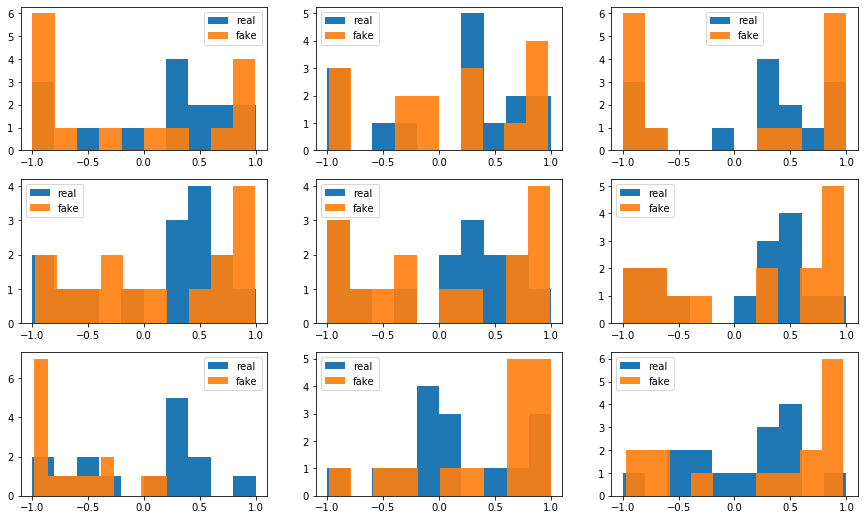

In [64]:
plt.figure(figsize=(15,9))
print("Distribuición original de cada caracteristica vs red Generadora sin entrenar")
for col in range(X_train.shape[1]):
    aux_real = X_train.iloc[:,col]
    aux_fake = data_fake[:,col]
    plt.subplot(3,3,col+1)
    plt.hist(aux_real, bins=10, label="real",)
    plt.hist(aux_fake, bins=10, label="fake", alpha=0.9)
    plt.legend()

(15, 2) (1000, 2)


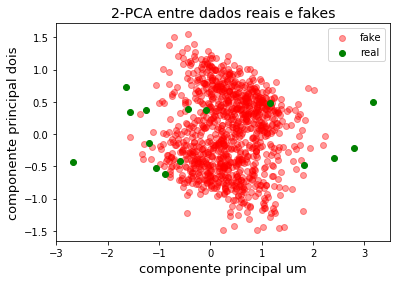

In [65]:
noise = np.random.normal(loc=0, scale=1, size=(1000,noise_input))
data_fake = G.predict(noise)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_fake_pca = pca.transform(data_fake)
print(X_train_pca.shape, X_fake_pca.shape)
plt.figure(figsize=(6,4))
plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="fake", alpha=0.4)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1)
plt.legend();

In [83]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [84]:
optimizerD = Adam(lr=0.0004, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

In [85]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [86]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [87]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_l = D.train_on_batch(x_combined_batch, y_combined_batch)
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_l = gan.train_on_batch(noise, y_mislabled)
 
        t_f = time()
        t = t_f - t_i
        t_i = time()
        d_loss.append(d_l[0])
        g_loss.append(g_l)
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
    return g_loss, d_loss

In [88]:
noise_input = 100
#Gerador
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = Adam(lr=0.0004, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  100
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_17 (Sequential)   (None, 9)                 5641      
_________________________________________________________________
sequential_18 (Sequential)   (None, 1)                 353       
Total params: 5,994
Trainable params: 5,641
Non-trainable params: 353
_________________________________________________________________


In [89]:
ep = 600
g_loss, d_loss = train(X_train, epochs=ep, batch_size=1, G=G, D=D, gan=gan, noise_input=noise_input)

epoch:[1/600] [Discriminator::d_loss: 0.726623],[Generator::loss: 1.490629], 2.665886[sec]
epoch:[2/600] [Discriminator::d_loss: 0.689651],[Generator::loss: 0.517254], 0.098561[sec]
epoch:[3/600] [Discriminator::d_loss: 0.547435],[Generator::loss: 0.533243], 0.096713[sec]
epoch:[4/600] [Discriminator::d_loss: 0.685778],[Generator::loss: 0.673438], 0.110836[sec]
epoch:[5/600] [Discriminator::d_loss: 0.604591],[Generator::loss: 1.401041], 0.098024[sec]
epoch:[6/600] [Discriminator::d_loss: 0.815891],[Generator::loss: 0.923540], 0.146216[sec]
epoch:[7/600] [Discriminator::d_loss: 0.710680],[Generator::loss: 0.910922], 0.120239[sec]
epoch:[8/600] [Discriminator::d_loss: 0.758059],[Generator::loss: 0.807625], 0.166950[sec]
epoch:[9/600] [Discriminator::d_loss: 0.595440],[Generator::loss: 1.181405], 0.171636[sec]
epoch:[10/600] [Discriminator::d_loss: 0.805177],[Generator::loss: 0.690854], 0.122676[sec]
epoch:[11/600] [Discriminator::d_loss: 0.732289],[Generator::loss: 1.312721], 0.098607[se

epoch:[90/600] [Discriminator::d_loss: 0.478256],[Generator::loss: 0.521496], 0.121310[sec]
epoch:[91/600] [Discriminator::d_loss: 0.459571],[Generator::loss: 1.266317], 0.123127[sec]
epoch:[92/600] [Discriminator::d_loss: 0.882851],[Generator::loss: 1.294356], 0.116249[sec]
epoch:[93/600] [Discriminator::d_loss: 0.509262],[Generator::loss: 0.932825], 0.107957[sec]
epoch:[94/600] [Discriminator::d_loss: 0.559109],[Generator::loss: 0.925701], 0.124111[sec]
epoch:[95/600] [Discriminator::d_loss: 0.936903],[Generator::loss: 0.625821], 0.128033[sec]
epoch:[96/600] [Discriminator::d_loss: 0.497490],[Generator::loss: 0.463735], 0.110181[sec]
epoch:[97/600] [Discriminator::d_loss: 0.868994],[Generator::loss: 0.612667], 0.113407[sec]
epoch:[98/600] [Discriminator::d_loss: 0.664853],[Generator::loss: 1.038262], 0.115368[sec]
epoch:[99/600] [Discriminator::d_loss: 0.509988],[Generator::loss: 0.412377], 0.128106[sec]
epoch:[100/600] [Discriminator::d_loss: 0.762067],[Generator::loss: 1.299975], 0

epoch:[180/600] [Discriminator::d_loss: 0.602741],[Generator::loss: 0.836610], 0.122325[sec]
epoch:[181/600] [Discriminator::d_loss: 0.574603],[Generator::loss: 0.672281], 0.107146[sec]
epoch:[182/600] [Discriminator::d_loss: 0.632360],[Generator::loss: 0.985549], 0.104741[sec]
epoch:[183/600] [Discriminator::d_loss: 0.703898],[Generator::loss: 0.522372], 0.101461[sec]
epoch:[184/600] [Discriminator::d_loss: 0.651523],[Generator::loss: 0.633564], 0.105457[sec]
epoch:[185/600] [Discriminator::d_loss: 0.469421],[Generator::loss: 0.657598], 0.107155[sec]
epoch:[186/600] [Discriminator::d_loss: 0.571648],[Generator::loss: 0.988564], 0.110134[sec]
epoch:[187/600] [Discriminator::d_loss: 0.621439],[Generator::loss: 0.537512], 0.104732[sec]
epoch:[188/600] [Discriminator::d_loss: 0.785210],[Generator::loss: 0.753311], 0.112095[sec]
epoch:[189/600] [Discriminator::d_loss: 0.697114],[Generator::loss: 1.159746], 0.114335[sec]
epoch:[190/600] [Discriminator::d_loss: 0.607111],[Generator::loss: 0.

epoch:[270/600] [Discriminator::d_loss: 0.596565],[Generator::loss: 0.836625], 0.127709[sec]
epoch:[271/600] [Discriminator::d_loss: 0.681035],[Generator::loss: 0.498565], 0.120155[sec]
epoch:[272/600] [Discriminator::d_loss: 0.584536],[Generator::loss: 0.673569], 0.102626[sec]
epoch:[273/600] [Discriminator::d_loss: 0.637012],[Generator::loss: 0.683842], 0.099671[sec]
epoch:[274/600] [Discriminator::d_loss: 0.672423],[Generator::loss: 0.707619], 0.098396[sec]
epoch:[275/600] [Discriminator::d_loss: 0.658742],[Generator::loss: 0.849935], 0.107786[sec]
epoch:[276/600] [Discriminator::d_loss: 0.643854],[Generator::loss: 0.762273], 0.116580[sec]
epoch:[277/600] [Discriminator::d_loss: 0.562389],[Generator::loss: 0.798071], 0.097218[sec]
epoch:[278/600] [Discriminator::d_loss: 0.658559],[Generator::loss: 0.786508], 0.107691[sec]
epoch:[279/600] [Discriminator::d_loss: 0.620356],[Generator::loss: 0.761378], 0.163629[sec]
epoch:[280/600] [Discriminator::d_loss: 0.668306],[Generator::loss: 0.

epoch:[360/600] [Discriminator::d_loss: 0.650607],[Generator::loss: 0.849649], 0.105338[sec]
epoch:[361/600] [Discriminator::d_loss: 0.693811],[Generator::loss: 0.786412], 0.103983[sec]
epoch:[362/600] [Discriminator::d_loss: 0.613370],[Generator::loss: 0.734486], 0.107002[sec]
epoch:[363/600] [Discriminator::d_loss: 0.752345],[Generator::loss: 0.910609], 0.101720[sec]
epoch:[364/600] [Discriminator::d_loss: 0.658673],[Generator::loss: 0.684802], 0.140131[sec]
epoch:[365/600] [Discriminator::d_loss: 0.679634],[Generator::loss: 0.654902], 0.112510[sec]
epoch:[366/600] [Discriminator::d_loss: 0.658774],[Generator::loss: 0.739004], 0.109300[sec]
epoch:[367/600] [Discriminator::d_loss: 0.593048],[Generator::loss: 0.752195], 0.114681[sec]
epoch:[368/600] [Discriminator::d_loss: 0.714737],[Generator::loss: 0.959353], 0.110994[sec]
epoch:[369/600] [Discriminator::d_loss: 0.596357],[Generator::loss: 0.956651], 0.108036[sec]
epoch:[370/600] [Discriminator::d_loss: 0.706247],[Generator::loss: 0.

epoch:[449/600] [Discriminator::d_loss: 0.733710],[Generator::loss: 0.572420], 0.110614[sec]
epoch:[450/600] [Discriminator::d_loss: 0.761550],[Generator::loss: 0.699270], 0.108487[sec]
epoch:[451/600] [Discriminator::d_loss: 0.798004],[Generator::loss: 0.557878], 0.112703[sec]
epoch:[452/600] [Discriminator::d_loss: 0.690410],[Generator::loss: 0.663710], 0.100987[sec]
epoch:[453/600] [Discriminator::d_loss: 0.651408],[Generator::loss: 0.928013], 0.108279[sec]
epoch:[454/600] [Discriminator::d_loss: 0.803532],[Generator::loss: 0.675097], 0.100912[sec]
epoch:[455/600] [Discriminator::d_loss: 0.664875],[Generator::loss: 0.865234], 0.103088[sec]
epoch:[456/600] [Discriminator::d_loss: 0.674950],[Generator::loss: 0.889040], 0.097854[sec]
epoch:[457/600] [Discriminator::d_loss: 0.755876],[Generator::loss: 0.818944], 0.117655[sec]
epoch:[458/600] [Discriminator::d_loss: 0.754843],[Generator::loss: 0.533674], 0.104415[sec]
epoch:[459/600] [Discriminator::d_loss: 0.717849],[Generator::loss: 0.

epoch:[539/600] [Discriminator::d_loss: 0.751323],[Generator::loss: 0.740814], 0.112355[sec]
epoch:[540/600] [Discriminator::d_loss: 0.640927],[Generator::loss: 0.549043], 0.108231[sec]
epoch:[541/600] [Discriminator::d_loss: 0.780256],[Generator::loss: 0.839933], 0.116573[sec]
epoch:[542/600] [Discriminator::d_loss: 0.732564],[Generator::loss: 0.556265], 0.112982[sec]
epoch:[543/600] [Discriminator::d_loss: 0.703590],[Generator::loss: 0.777971], 0.108931[sec]
epoch:[544/600] [Discriminator::d_loss: 0.598093],[Generator::loss: 0.630444], 0.107678[sec]
epoch:[545/600] [Discriminator::d_loss: 0.641949],[Generator::loss: 0.626416], 0.113240[sec]
epoch:[546/600] [Discriminator::d_loss: 0.648461],[Generator::loss: 0.577930], 0.107043[sec]
epoch:[547/600] [Discriminator::d_loss: 0.589335],[Generator::loss: 0.732769], 0.104345[sec]
epoch:[548/600] [Discriminator::d_loss: 0.773169],[Generator::loss: 0.719352], 0.106827[sec]
epoch:[549/600] [Discriminator::d_loss: 0.687693],[Generator::loss: 0.

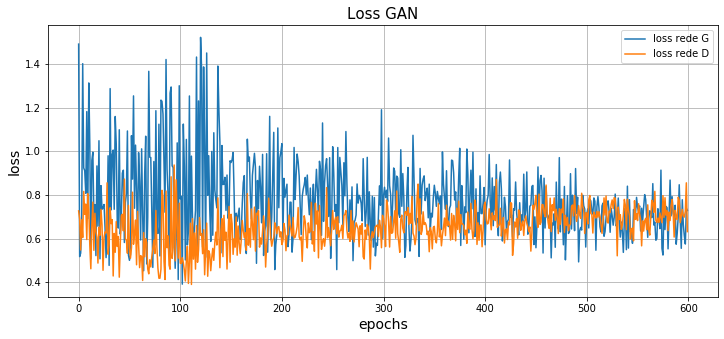

In [90]:
plt.figure(figsize=(12,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(ep), g_loss, label="loss rede G")
plt.plot(range(ep), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

Distribuición original de cada caracteristica vs red Generadora entrenada


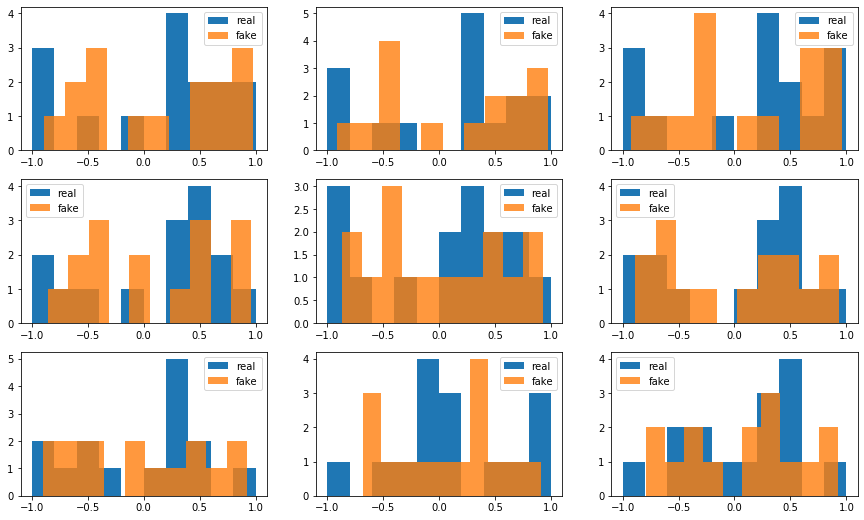

In [91]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0],noise_input))
data_fake = G.predict(noise)
plt.figure(figsize=(15,9))
print("Distribuición original de cada caracteristica vs red Generadora entrenada")
for col in range(X_train.shape[1]):
    aux_real = X_train.iloc[:,col]
    aux_fake = data_fake[:,col]
    plt.subplot(3,3,col+1)
    plt.hist(aux_real, bins=10, label="real",)
    plt.hist(aux_fake, bins=10, label="fake", alpha=0.8)
    plt.legend()

(15, 2) (15, 2)


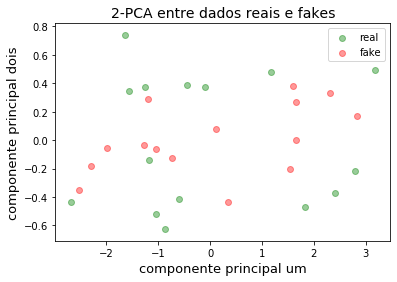

In [92]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_fake_pca = pca.transform(data_fake)
print(X_train_pca.shape, X_fake_pca.shape)
plt.figure(figsize=(6,4))
plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=0.4)
plt.scatter(X_fake_pca[:500,0], X_fake_pca[:500,1], color="red", label="fake", alpha=0.4)
plt.legend();

In [96]:
fakes = G.predict(np.random.normal(0,1,(5000,noise_input)))
print("Dados fake: ", fakes.shape)
print()
D_predict_fake = D.predict_classes(fakes)
print("-------------- Discriminador com dados fake --------------")
print("porcentagem de dados que o discriminador acredita reais: ", np.round(np.mean(D_predict_fake==1),4))
print("porcentagem de dados que o discriminador acredita fakes: ", np.round(np.mean(D_predict_fake==0),4))
print()
D_predict_real = D.predict_classes(X_train)
print("-------------- Discriminador com dados reais --------------")
print("porcentagem de dados que o discriminador acredita reais: ", np.round(np.mean(D_predict_real==1),4))
print("porcentagem de dados que o discriminador acredita fakes: ", np.round(np.mean(D_predict_real==0),4))

Dados fake:  (5000, 9)

-------------- Discriminador com dados fake --------------
porcentagem de dados que o discriminador acredita reais:  0.5412
porcentagem de dados que o discriminador acredita fakes:  0.4588

-------------- Discriminador com dados reais --------------
porcentagem de dados que o discriminador acredita reais:  0.8
porcentagem de dados que o discriminador acredita fakes:  0.2


In [98]:
import plotly.express as px

real = X_train.copy()
real["cor"] = 1
fake = pd.DataFrame(data_fake, columns=X_train.columns).copy()
fake["cor"] = 2
data = pd.concat([real,fake])

fig = px.parallel_coordinates(data, color="cor", dimensions={"BB9","BB10","BB17","BB19","BB20","BB11",
                                                             "BB12","BB18"},
                             color_continuous_scale=px.colors.diverging.Tealrose,)
fig.show()

(15, 2) (500, 2)
Distribuición original de cada caracteristica vs red Generadora entrenada


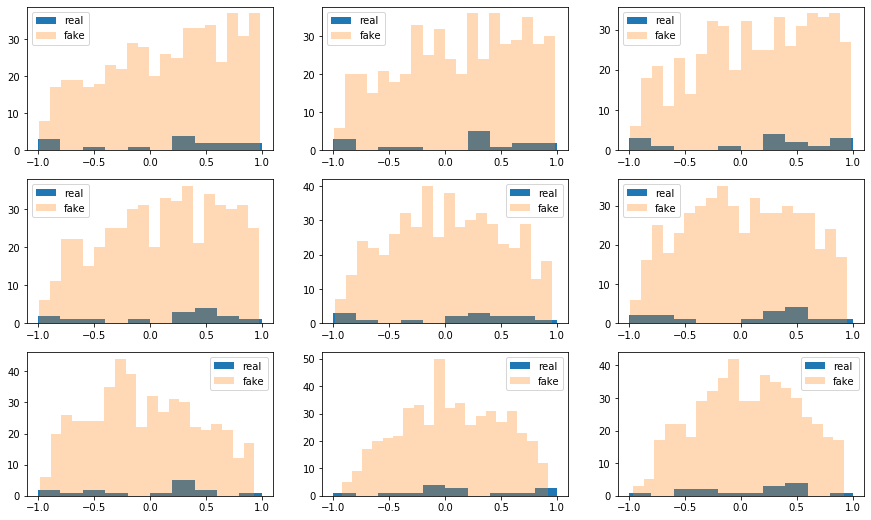

In [120]:
noise = np.random.normal(loc=0, scale=1, size=(500,noise_input))
data_fake = G.predict(noise)
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_fake_pca = pca.transform(data_fake)
print(X_train_pca.shape, X_fake_pca.shape)

plt.figure(figsize=(15,9))
print("Distribuición original de cada caracteristica vs red Generadora entrenada")
for col in range(X_train.shape[1]):
    aux_real = X_train.iloc[:,col]
    aux_fake = data_fake[:,col]
    plt.subplot(3,3,col+1)
    plt.hist(aux_real, bins=10, label="real")
    plt.hist(aux_fake, bins=20, label="fake", alpha=0.3)
    #plt.yscale("log")
    plt.legend()

In [121]:
#no_hkg = np.array([6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553])
no_hkg = np.array([6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364])
Nhkg = pca.transform(no_hkg.reshape(1,-1))

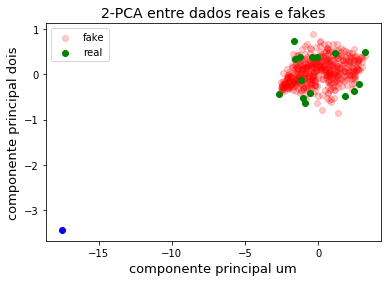

In [122]:
plt.figure(figsize=(6,4))
plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="fake", alpha=0.2)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1)
plt.scatter(Nhkg[:,0], Nhkg[:,1], color="blue")
plt.legend();